In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, average_precision_score
)
from sklearn.utils import resample

import numpy as np
import pandas as pd

In [25]:
archivo = "..\\Datos\\DatosConYConFeatures.xlsx"
archivo = "..\\Datos\\DatosConYConFeatures - Balanceado.xlsx"

tabla = pd.read_excel(archivo, parse_dates=["timestamp_ventana"])
tabla = tabla.dropna()


In [26]:
#columnas_excluir = ["timestamp", "host", "Y", "reinicio", "falloBruto", "falloPersistente"]
columnas_excluir = ["timestamp_ventana", "host", "Y"]


# Separar clases
clase0 = tabla[tabla["Y"] == 0]
clase1 = tabla[tabla["Y"] == 1]

# Submuestreo de clase 0
clase0_eq = resample(clase0,
                     replace=False,    # no reemplazar
                     n_samples=len(clase1), # mismo tamaño que clase 1
                     random_state=42)

# Dataset balanceado
tabla_eq = pd.concat([clase0_eq, clase1])

#las X serán todas las columnas menos la primera ni última
X = tabla_eq.drop(columns=columnas_excluir)

y = tabla_eq["Y"]

X.shape, y.shape

((808, 22), (808,))

In [27]:
#columnas_excluir = ["timestamp", "host", "Y", "reinicio", "falloBruto", "falloPersistente"]
columnas_excluir = ["timestamp_ventana", "host", "Y"]

X = tabla.drop(columns=columnas_excluir)

y = tabla["Y"]

X.shape, y.shape

((808, 22), (808,))

In [39]:
train_idx = np.load("..\\Utilidades\\indices\\train_idx.npy")
val_idx   = np.load("..\\Utilidades\\indices\\val_idx.npy")
test_idx  = np.load("..\\Utilidades\\indices\\test_idx.npy")

X_train, y_train = X.iloc[train_idx], y[train_idx]
X_val,   y_val   = X.iloc[val_idx],   y[val_idx]
X_test,  y_test  = X.iloc[test_idx],  y[test_idx]

from collections import Counter
print("train dist:", Counter(y[train_idx].tolist()))
print("val   dist:", Counter(y[val_idx].tolist()))
print("test  dist:", Counter(y[test_idx].tolist()))


train dist: Counter({1: 195, 0: 183})
val   dist: Counter({0: 101, 1: 86})
test  dist: Counter({1: 123, 0: 120})


In [40]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
sfs = SequentialFeatureSelector(rf, n_features_to_select='auto', tol=0.001, direction='forward', n_jobs=-1)
sfs.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,n_features_to_select,'auto'
,tol,0.001
,direction,'forward'
,scoring,None
,cv,5
,n_jobs,-1
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2


In [41]:
np.sum(sfs.get_support())  # Number of selected features

np.int64(3)

In [42]:
sfs.get_support()
sfs.get_feature_names_out()


array(['Paquetes_unicast_enviados_ETH_mean',
       'Paquetes_unicast_recibidos_ETH_std', 'Trafico_LAN_Recibido_std'],
      dtype=object)

In [43]:
rf_final = RandomForestClassifier(n_estimators=100, random_state=42)
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)
rf_final.fit(X_train_sfs, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [44]:
rf_final.score(X_test_sfs, y_test)

0.9835390946502057

In [45]:
#Métricas para evaluar el modelo
# Predicciones
y_pred = rf_final.predict(X_test_sfs)
y_proba = rf_final.predict_proba(X_test_sfs)[:,1]  # para ROC-AUC

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))# ESTE SÍ
print("ROC-AUC:", roc_auc_score(y_test, y_proba)) #ESTE SÍ
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9835390946502057
Precision: 0.983739837398374
Recall: 0.983739837398374
F1: 0.983739837398374
ROC-AUC: 0.9941734417344174
Matriz de confusión:
 [[118   2]
 [  2 121]]


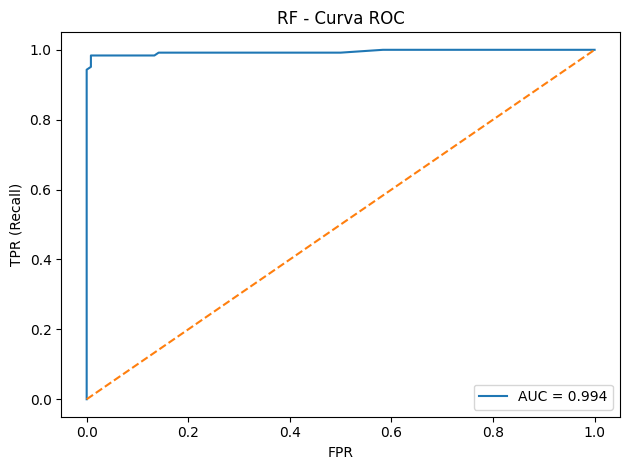

In [35]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_roc = roc_auc_score(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("RF - Curva ROC")
plt.legend()
plt.tight_layout()
plt.show()

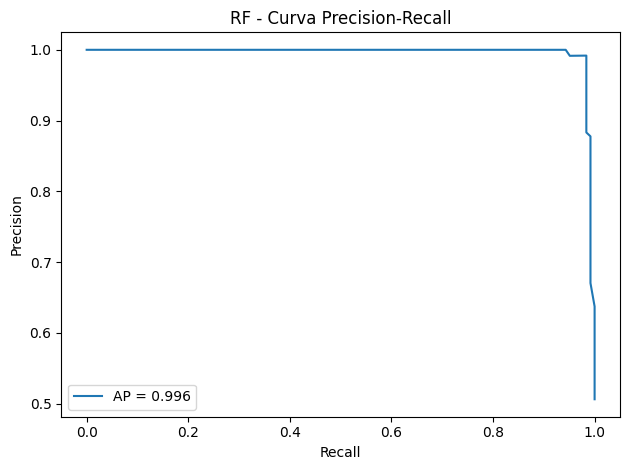

In [36]:
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
plt.figure()
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("RF - Curva Precision-Recall")
plt.legend()
plt.tight_layout()
plt.show()

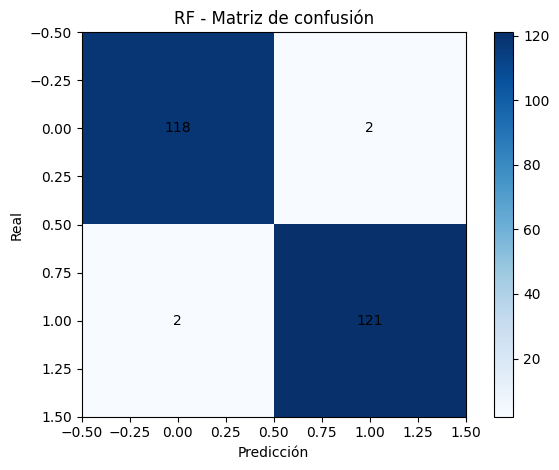

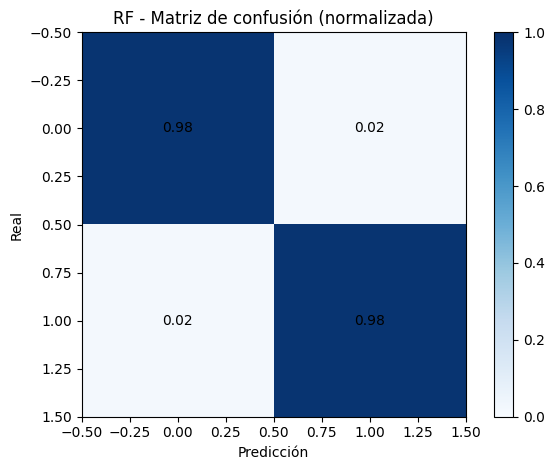

In [37]:
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("RF - Matriz de confusión")
plt.xlabel("Predicción"); plt.ylabel("Real")
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.colorbar(); plt.tight_layout(); plt.show()

cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure()
plt.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
plt.title("RF - Matriz de confusión (normalizada)")
plt.xlabel("Predicción"); plt.ylabel("Real")
for i in range(2):
    for j in range(2):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
plt.colorbar(); plt.tight_layout(); plt.show()

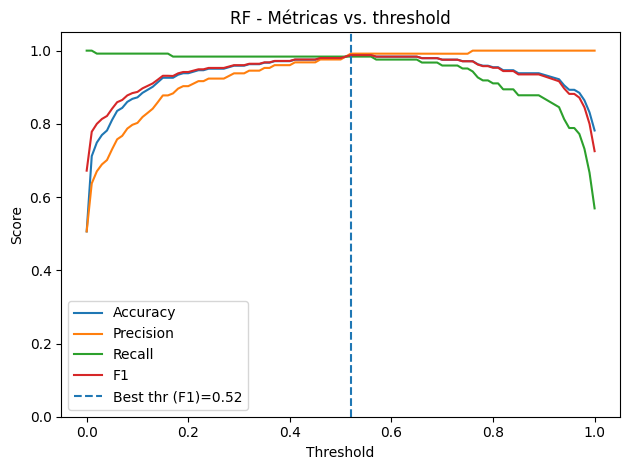

In [38]:
ths = np.linspace(0.0, 1.0, 101)
accs, precs, recs, f1s = [], [], [], []
for t in ths:
    yp = (y_proba >= t).astype(int)
    accs.append(accuracy_score(y_test, yp))
    precs.append(precision_score(y_test, yp, zero_division=0))
    recs.append(recall_score(y_test, yp, zero_division=0))
    f1s.append(f1_score(y_test, yp, zero_division=0))
accs, precs, recs, f1s = map(np.array, (accs, precs, recs, f1s))

best_idx = np.argmax(f1s)
best_thr = ths[best_idx]
plt.figure()
plt.plot(ths, accs, label="Accuracy")
plt.plot(ths, precs, label="Precision")
plt.plot(ths, recs, label="Recall")
plt.plot(ths, f1s, label="F1")
plt.axvline(best_thr, linestyle="--", label=f"Best thr (F1)={best_thr:.2f}")
plt.ylim(0, 1.05)
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title("RF - Métricas vs. threshold")
plt.legend(); plt.tight_layout(); plt.show()